### Load Data

In [10]:
import codecs
import nltk
from nltk.stem import WordNetLemmatizer

cn_stopwords = set([ line.rstrip() for line in codecs.open('dataset/cn_stop_words.txt',"r", encoding="utf-8")])
en_stopwords = set([ line.rstrip() for line in codecs.open('dataset/en_stop_words.txt',"r", encoding="utf-8")])
lemmatizer = WordNetLemmatizer()

def remove_new_line(text):
    text = text.replace('\n', '')
    text = ' '.join(text.split())
    return text

def lemmatize(review):
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    corpus = []
    for y in review:
        if y not in en_stopwords:
            corpus.append(lemmatizer.lemmatize(y))
    return ' '.join(corpus)

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ds\AppData\Roaming\nltk_data...


True

In [69]:
import pandas as pd
import numpy as np

df_attributes = pd.read_csv('dataset/stories_attributes.csv')
df_text = pd.read_csv('dataset/stories_in_text.csv')
df_translated = pd.read_csv('dataset/stories_translated.csv')

df = pd.merge(df_attributes, df_text, on=['filename', 'Language'])
df = pd.merge(df, df_translated, on=['filename', 'Language'])

# 0 = truth, 1 = deceptive
df['label'] = np.where(df['Story_type'] == 'Deceptive Story', 1, 0)
df['idx'] = range(len(df))
df['text_line'] = df['text'].apply(remove_new_line)
df['text_lemma'] = df['text_english'].apply(lemmatize)
df = df.drop(columns=['Story_type'])
df

,filename,Language,text,text_english,label,idx,text_line,text_lemma
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,"In the winter of 2021, I went back to my homet...",0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...,winter hometown visit grandmother good health ...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,I finally realized my dream of traveling to Yu...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...,finally realized dream traveling yunnan summer...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,This is my story. My journey begins with the f...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...,story journey famous forbidden city largest pr...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,"In 2020, I registered for the school's organiz...",0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...,registered school organized study tour united ...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,"Today, I would like to share with you my trip ...",0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...,today share trip shaanxi year stepped ancient ...
...,...,...,...,...,...,...,...,...
95,00096.wav,English,Uh. \nW is a\n uh my friends and I decided to...,Uh. W is a uh my friends and I decided to go h...,0,95,Uh. W is a uh my friends and I decided to go h...,uh uh friend decided hiking life true uh left ...
96,00097.wav,Chinese,上周\n我前往宜家\n孤儿院\n去看望我大学时期志愿服务时认识的小男孩，\n浩浩，\n那是一...,"Last week, I went to IKEA Orphanage to visit t...",1,96,上周我前往宜家孤儿院去看望我大学时期志愿服务时认识的小男孩，浩浩，那是一个安静的冬日午后阳光...,week ikea orphanage visit boy met college volu...
97,00098.wav,Chinese,呃上个周末我和我的朋友们准备去参加一场徒步旅行，\n然后目标是一片森林，\n那天的天气比较阴...,"Last weekend, my friends and I were planning t...",0,97,呃上个周末我和我的朋友们准备去参加一场徒步旅行，然后目标是一片森林，那天的天气比较阴沉，并且...,weekend friend planning participate hiking tri...
98,00099.wav,Chinese,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，\n我们都挺喜欢艺术的，所以就提前计...,"Ah, once in a while, my friends and I went to ...",1,98,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，我们都挺喜欢艺术的，所以就提前计划好...,friend attend weekend art exhibition love art ...


### Features from Text

In [4]:
import re

def count_modal_particles(text):
    particles = [
        '啊', '呀', '啦', '吧', '呢', '嘛', '呗', '么', '噢', '呃', '额', '唔', '嗯',
        ' uh ', 'uh,', '\nuh ', 'uh.', ' oh ', 'oh,', '\noh ', 'oh.', ' um ', 'um,', '\num ', 'um.', ' ah ', 'ah,', '\nah ', 'ah.',
    ]
    count = 0
    for particle in particles:
        count += len(re.findall(particle, text.lower()))
    return count

def count_new_line(text):
    return len(re.findall('\n', text))

def calculate_repetition(text):
    words = [w for w in text.split() if w]
    if not words:
        return 0
        
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    repeated_words = sum(count - 1 for count in word_counts.values())
    repetition_ratio = repeated_words / len(words)
    
    return repetition_ratio

def count_stop_words(lang, text):
    stopwords = cn_stopwords if lang == 'Chinese' else en_stopwords
    count = 0
    for word in stopwords:
        pattern = r'\b' + re.escape(word) + r'\b'
        try:
            matches = re.findall(pattern, text.lower())
            count += len(matches)
        except re.error:
            continue
    return count

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Basic Information
feats = {
    
    'is_cn': df['Language'] == 'Chinese', 
    'modal_particles': df['text'].apply(count_modal_particles),
    'new_line': df['text'].apply(count_new_line),
    'repetition': df['text_line'].apply(calculate_repetition),
    'stop_words': [count_stop_words(row['Language'], row['text_line']) 
                  for _, row in df.iterrows()],
    'length_en': df['text_english'].apply(len),
    'word_count_lemma': df['text_lemma'].apply(lambda x: x.split()) \
                        .apply(len).apply(lambda x: x+1),
}

# TF-IDF Related Features
tfidf_en = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 2),
    stop_words='english'
)
tfidf_matrix_en = tfidf_en.fit_transform(df['text_lemma'])

feats['tfidf_vec_len'] = pd.Series([len(x.indices) for x in tfidf_matrix_en])
feats['tfidf_mean'] = pd.Series(np.array(tfidf_matrix_en.mean(axis=1)).flatten())
feats['tfidf_std'] =  pd.Series([np.std(x.data) for x in tfidf_matrix_en])

feature_names = tfidf_en.get_feature_names_out()
top_words = []
for doc in tfidf_matrix_en:
    word_idx = doc.argmax()
    top_words.append(feature_names[word_idx])
df['top_tfidf_word'] = top_words

for word in feature_names[:25]:
    if word not in ['beijing', 'classmate', 'culture', 'book', 'delicious', 'face', 'bit']:
        feats[f'has_{word}'] = df['text_lemma'].apply(lambda x: 1 if word in x else 0)

df_feats = pd.DataFrame(feats)
df_feats

,is_cn,modal_particles,new_line,repetition,stop_words,length_en,word_count_lemma,tfidf_vec_len,tfidf_mean,tfidf_std,...,has_college,has_day,has_decided,has_deep,has_didnt,has_dream,has_evening,has_excited,has_experience,has_eye
0,True,2,44,0.000000,39,1730,116,30,0.051354,0.063489,...,0,0,0,0,1,0,0,0,0,1
1,True,0,29,0.000000,36,1898,153,28,0.033481,0.146343,...,0,1,0,1,0,1,1,0,0,0
2,True,0,33,0.000000,38,2158,173,24,0.039750,0.119308,...,0,0,0,0,0,0,0,0,0,0
3,True,6,43,0.000000,44,2061,146,25,0.036762,0.135560,...,1,1,0,0,0,0,0,0,0,1
4,True,0,33,0.000000,31,1701,139,16,0.034039,0.131302,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,19,42,0.373786,142,996,70,16,0.028219,0.177182,...,0,1,1,0,1,0,0,0,0,0
96,True,1,84,0.000000,53,1844,137,23,0.040095,0.114405,...,1,0,0,0,0,0,0,1,0,1
97,True,13,35,0.000000,33,1433,79,15,0.035623,0.101325,...,0,1,0,1,1,0,0,0,0,0
98,True,9,29,0.000000,26,1514,103,17,0.027052,0.183036,...,0,0,0,1,0,0,0,0,1,0


### Do Boosting

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

USE_XGBOOST = True
USE_LIGHTGBM = False
USE_STACKING = False
N_JOBS = 8

X = df_feats
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

base_models = []
if USE_XGBOOST:
    base_models.append(('xgboost', XGBClassifier(
        random_state=0,
        n_jobs=N_JOBS,
        device='cuda',
        use_label_encoder=False,
        eval_metric='mlogloss'
    )))
if USE_LIGHTGBM:
    base_models.append(('lightgbm', LGBMClassifier(
        device='gpu',
        random_state=0,
        n_jobs=N_JOBS,
        verbose=-1
    )))

if USE_STACKING and len(base_models) > 1:
    print(f"Stacking [{', '.join([name for name, _ in base_models])}]")
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(random_state=0, n_jobs=N_JOBS),
        passthrough=False,
        cv=5,
        n_jobs=N_JOBS
    )
    clf = OneVsRestClassifier(stacking_clf, n_jobs=N_JOBS)
else:
    print(f"Using {base_models[0][0]}")
    clf = OneVsRestClassifier(base_models[0][1], n_jobs=N_JOBS)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Report:")
print(classification_report(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", f'{roc_auc:.2f}')

Using xgboost
Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.57      0.40      0.47        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.55      0.55      0.54        20

ROC AUC: 0.69


In [63]:
if not USE_STACKING:
    feature_importance = clf.estimators_[0].feature_importances_
    feature_names = df_feats.columns
    
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(df_importance.to_string(index=False))

         Feature  Importance
         has_eye    0.128622
         has_day    0.087408
  has_atmosphere    0.085024
           is_cn    0.058400
      repetition    0.053324
word_count_lemma    0.049449
       has_didnt    0.046074
   has_afternoon    0.045682
       tfidf_std    0.041094
     has_excited    0.039675
         has_air    0.037830
 modal_particles    0.033999
   tfidf_vec_len    0.032937
       length_en    0.032249
     has_decided    0.032028
        has_city    0.030335
      tfidf_mean    0.030154
      stop_words    0.030013
        new_line    0.028536
    has_building    0.022115
       has_dream    0.016396
  has_experience    0.014677
   has_beautiful    0.007167
      has_beauty    0.006744
     has_arrived    0.006629
        has_deep    0.003440
     has_college    0.000000
     has_evening    0.000000


### Result Analysis

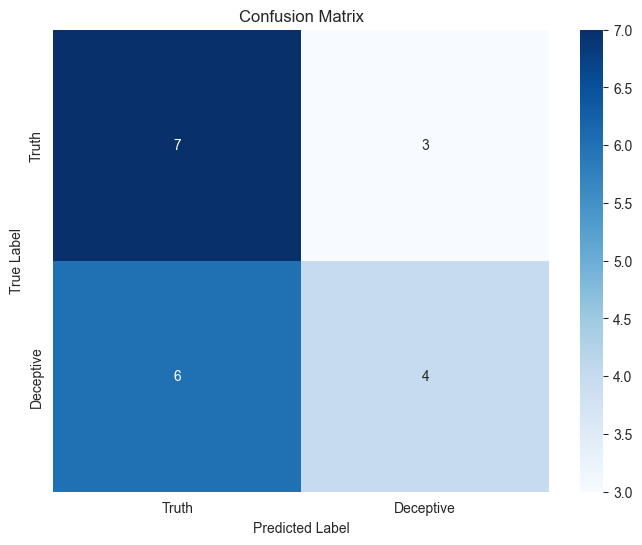

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deceptive'],
            yticklabels=['Truth', 'Deceptive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()